In [1]:
%load_ext autoreload
%autoreload 2
from src.datasets.euclidean import SineDataset

n_points = 1000
dataset = SineDataset(n_points)

In [13]:
from train_toy_mc import LitManifoldMetricCorrector

ckpt_path = 'lightning_logs/sine_1000np_800ws_1str_16hd_2od_automatic_cc/version_0/checkpoints/epoch=999-step=1000.ckpt'
#ckpt_path = 'lightning_logs/sine_1000np_800ws_1str_16hd_2od_100_cc/version_0/checkpoints/epoch=999-step=1000.ckpt' 
model = LitManifoldMetricCorrector.load_from_checkpoint(ckpt_path)

In [15]:
model.correction_coeff
model.corrected_manifold.beta

125.88682556152344

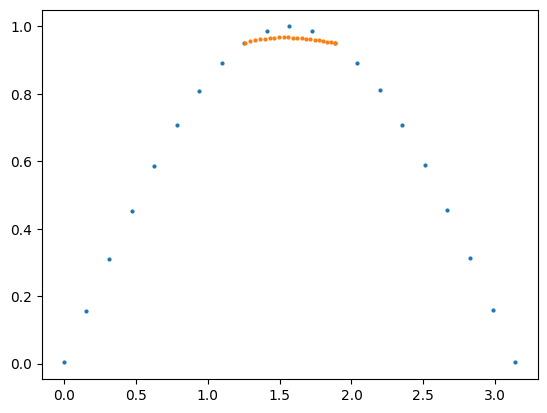

In [18]:
import torch
import matplotlib.pyplot as plt

p0 = dataset.points[400]
p1 = dataset.points[600]

n_interps = 21
ts = torch.linspace(0, 1, n_interps)
preds = torch.zeros(n_interps, 2)
true_vals = torch.zeros(n_interps, 2)
for i, t in enumerate(ts):
    preds[i] = model.corrected_manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([t])).squeeze()
    idx = int(t * (n_points - 1))
    true_vals[i] = dataset.points[idx]
    
preds = preds.detach().numpy()

# plot true points
plt.scatter(true_vals[:,0], true_vals[:,1], s=4, label='true')
# plot predicted points
plt.scatter(preds[:,0], preds[:,1], s=4, label='predicted')

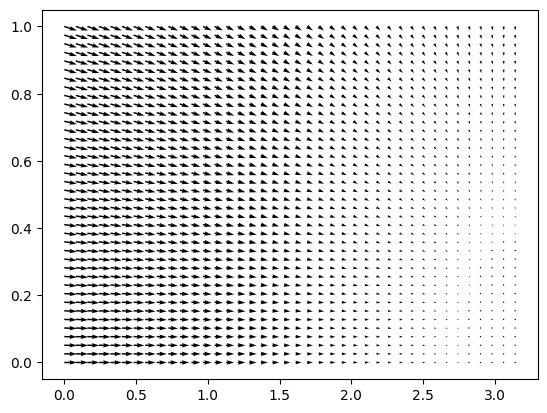

In [4]:
# test quiver plot
import numpy as np
x = np.linspace(0, np.pi, 40)
y = np.linspace(0, 1, 40)
xv, yv = np.meshgrid(x, y)

xy = np.vstack([xv.ravel(), yv.ravel()]).T
ps = torch.from_numpy(xy[None])
target = dataset.points[-1][None, None]

from src.manifolds.euclidean import Euclidean
uncorrected_manifold = Euclidean(2)

logs = uncorrected_manifold.log(ps, target)
logs = logs.squeeze([0, 2])
logs_x = logs[:,0].detach().numpy()
logs_y = logs[:,1].detach().numpy()
plt.quiver(xv, yv, logs_x, logs_y, width=0.003)

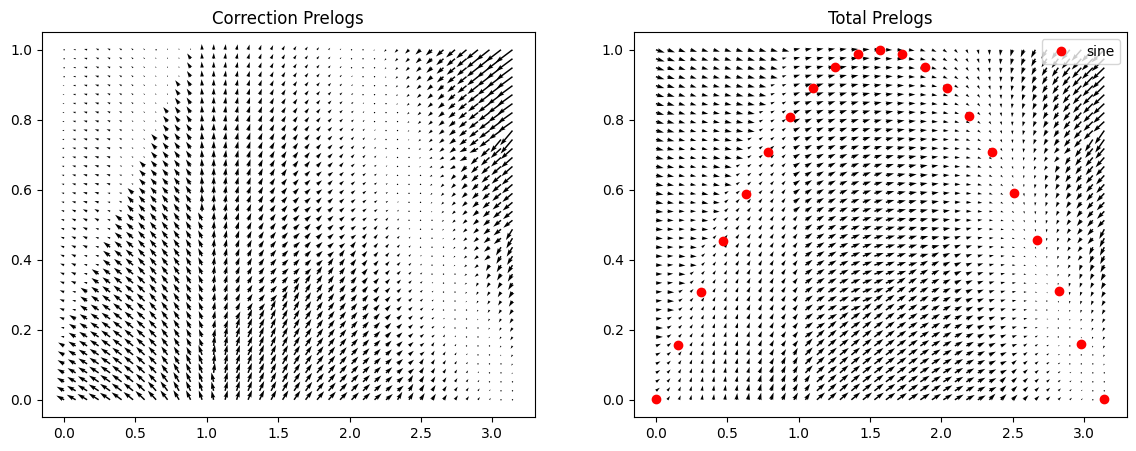

In [5]:
total_prelogs, _, _, correction_prelogs = corrected_manifold.s_prelog(ps.float(), target.float())
correction_prelogs = correction_prelogs.squeeze([0, 2])
total_prelogs = total_prelogs.squeeze([0, 2])

# initialize figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

corr_prelogs_x = correction_prelogs[:,0].detach().numpy()
corr_prelogs_y = correction_prelogs[:,1].detach().numpy()
axs[0].quiver(xv, yv, corr_prelogs_x, corr_prelogs_y, width=0.003)
axs[0].set_title('Correction Prelogs')

total_prelogs_x = total_prelogs[:,0].detach().numpy()
total_prelogs_y = total_prelogs[:,1].detach().numpy()
axs[1].quiver(xv, yv, total_prelogs_x, total_prelogs_y, width=0.003)
axs[1].set_title('Total Prelogs')
axs[1].plot(true_vals[:,0], true_vals[:,1], 'ro', label='sine')
axs[1].legend()